## データのダウンロード
MNISTのデータをkerasのサイトからダウンロードします。

In [53]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


In [96]:
batch_size = 100
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1.0

In [97]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import metrics
from keras import backend as K

In [98]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [99]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [100]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [101]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [104]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [105]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
# 約25分

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s - loss: 191.7322 - val_loss: 173.3068
Epoch 2/10
60000/60000 [==============================] - 15s - loss: 172.0132 - val_loss: 169.9070
Epoch 3/10
60000/60000 [==============================] - 14s - loss: 170.0636 - val_loss: 169.6632
Epoch 4/10
60000/60000 [==============================] - 14s - loss: 169.7233 - val_loss: 172.0980
Epoch 5/10
60000/60000 [==============================] - 15s - loss: 170.2691 - val_loss: 167.9033
Epoch 6/10
60000/60000 [==============================] - 14s - loss: 171.1100 - val_loss: 167.3268
Epoch 7/10
60000/60000 [==============================] - 14s - loss: 172.4715 - val_loss: 175.4807
Epoch 8/10
60000/60000 [==============================] - 15s - loss: 174.2179 - val_loss: 171.9717
Epoch 9/10
60000/60000 [==============================] - 15s - loss: 176.1568 - val_loss: 193.6804
Epoch 10/10
60000/60000 [=========================

In [106]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline


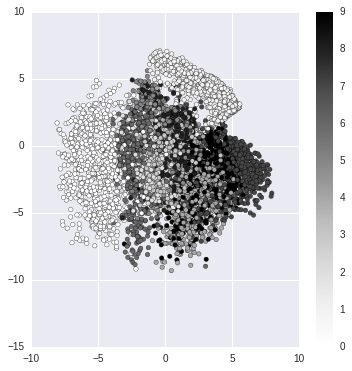

In [107]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

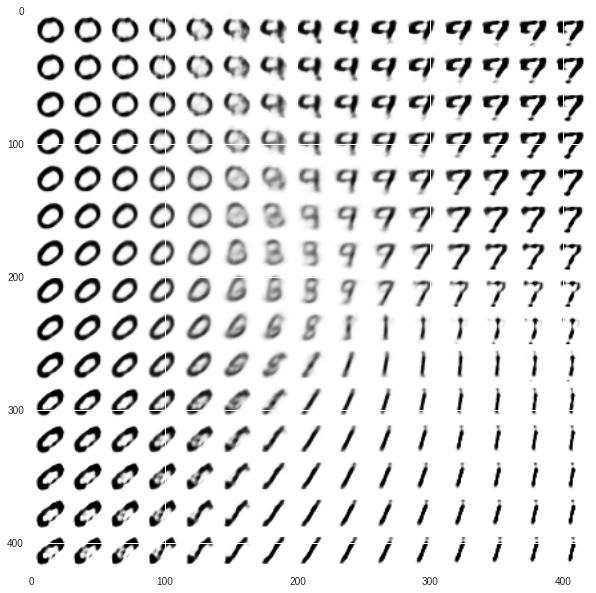

In [108]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()